# 🔋 Phase 2b: Ekstraksi Kapasitas & True OCV (Dataset Final 1 Siklus Murni)

**Tujuan Eksperimen:**
Mengekstrak nilai parameter fundamental baterai LiFePO4 dari pengujian 1 siklus murni:
1. Menguras sisa energi (Residual Discharge) hingga SoC 0% absolut.
2. Mengisi daya hingga penuh (Charge 100%).
3. Menguras daya kembali (Discharge 100% -> 0%).

**Dataset:** `DCC 2.5V - CCV 3.65 - DCC 2.5V.csv`

### 1. Perhitungan Kapasitas ($Ah$) dan Efisiensi ($\eta$) dengan Integrasi Waktu

Karena arus berfluktuasi terhadap waktu, Kapasitas (Ampere-Hour) dan Energi (Watt-Hour) tidak bisa dihitung dengan perkalian biasa. Kita menggunakan metode **Integrasi Numerik (Riemann Sum)** terhadap data deret waktu (Time-Series).

**Rumus Kapasitas Listrik (Ah):**
Kapasitas adalah akumulasi arus yang mengalir setiap detiknya.
$$Q_{Ah} = \sum_{t=0}^{T} \frac{I(t) \times \Delta t}{3600}$$

**Rumus Energi Listrik (Wh):**
Energi adalah akumulasi daya (Arus $\times$ Tegangan) setiap detiknya.
$$E_{Wh} = \sum_{t=0}^{T} \frac{I(t) \times V(t) \times \Delta t}{3600}$$

**Rumus Efisiensi Coulombic & Energi:**
Sesuai Hukum Termodinamika, efisiensi adalah perbandingan antara energi yang bisa dikeluarkan (*Discharge*) dengan energi yang telah dimasukkan sebelumnya (*Charge*).
$$Coulombic\_Efficiency\ (\eta_{Ah}) = \left( \frac{Q_{Discharge}}{Q_{Charge}} \right) \times 100\%$$
$$Energy\_Efficiency\ (\eta_{Wh}) = \left( \frac{E_{Discharge}}{E_{Charge}} \right) \times 100\%$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 6)

# =========================================================
# LOAD DATA & DETEKSI BLOK
# =========================================================
def load_zke_data(filepath):
    skip_rows = 0
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if "Time(S)" in line:
                skip_rows = i
                break
    df = pd.read_csv(filepath, skiprows=skip_rows)
    df.columns = [col.strip() for col in df.columns]
    return df

df_raw = load_zke_data("DCC 2.5V - CCV 3.65 - DCC 2.5V.csv")
df_raw['dt'] = df_raw['Time(S)'].diff().fillna(0)

# Deteksi Fase Charge dan Discharge
df_raw['Is_Active'] = df_raw['Cur(A)'] > 0.05
df_raw['Block'] = (df_raw['Is_Active'] != df_raw['Is_Active'].shift(1)).cumsum()
active_blocks = df_raw[df_raw['Is_Active']]['Block'].unique()

# Block 1 = Residual Discharge, Block 2 = C-CV Charge Utama, Block 3 = D-CC Discharge Utama
ind_Chg = df_raw[df_raw['Block'] == active_blocks[1]].index.tolist()
ind_Dis = df_raw[df_raw['Block'] == active_blocks[2]].index.tolist()

# =========================================================
# IMPLEMENTASI RUMUS INTEGRASI (Ah & Wh)
# =========================================================
Ah_Chg = (df_raw.loc[ind_Chg, 'Cur(A)'] * df_raw.loc[ind_Chg, 'dt']).sum() / 3600
Ah_Dis = (df_raw.loc[ind_Dis, 'Cur(A)'] * df_raw.loc[ind_Dis, 'dt']).sum() / 3600

Wh_Chg = (df_raw.loc[ind_Chg, 'Cur(A)'] * df_raw.loc[ind_Chg, 'Vol(V)'] * df_raw.loc[ind_Chg, 'dt']).sum() / 3600
Wh_Dis = (df_raw.loc[ind_Dis, 'Cur(A)'] * df_raw.loc[ind_Dis, 'Vol(V)'] * df_raw.loc[ind_Dis, 'dt']).sum() / 3600

print("="*60)
print("📊 HASIL ANALISIS KAPASITAS & EFISIENSI")
print("="*60)
print(f"Kapasitas Aktual Baterai (Q25) : {Ah_Dis:.4f} Ah")
print(f"Coulombic Efficiency (Ah)      : {(Ah_Dis/Ah_Chg)*100:.2f} %")
print(f"Energy Efficiency (Wh)         : {(Wh_Dis/Wh_Chg)*100:.2f} %")
print("="*60)

📊 HASIL ANALISIS KAPASITAS & EFISIENSI
Kapasitas Aktual Baterai (Q25) : 20.7986 Ah
Coulombic Efficiency (Ah)      : 99.68 %
Energy Efficiency (Wh)         : 96.38 %


### 2. Ekstraksi True OCV (Metode Hysteresis Blending)

Kurva tegangan saat pengisian ($V_{Charge}$) selalu berada di atas True OCV karena adanya tegangan berlebih (*Overpotential*). Sebaliknya, kurva saat pengosongan ($V_{Discharge}$) selalu berada di bawahnya. Jarak antara kedua kurva ini disebut **Hysteresis**.

Untuk mencari True OCV (Tegangan Murni saat baterai istirahat), kita menggunakan algoritma *Hysteresis Blending* (Plett, 2015).

**Langkah 1: Menghitung Voltage Drop Awal & Akhir ($IR_{drop}$)**
Kita mengukur perbedaan tegangan tepat sebelum arus menyala dan sesaat setelah arus menyala.
$$IR_{drop} = |V_{active} - V_{rest}|$$

**Langkah 2: Koreksi Tegangan Dinamis (Blending)**
Kita mengurangkan $IR_{drop}$ dari kurva Charge, dan menambahkannya ke kurva Discharge dengan pembobotan linear.
$$V_{Chg\_Corrected}(SoC) = V_{Chg\_Raw} - IR_{blend\_C}$$
$$V_{Dis\_Corrected}(SoC) = V_{Dis\_Raw} + IR_{blend\_D}$$

**Langkah 3: Mencari Nilai Tengah (True OCV)**
Setelah dikoreksi, True OCV adalah garis tengah yang membelah kedua kurva tersebut pada setiap titik SoC yang sama.
$$True\_OCV(SoC) = \frac{V_{Chg\_Corrected}(SoC) + V_{Dis\_Corrected}(SoC)}{2}$$

In [2]:
# =========================================================
# IMPLEMENTASI ALGORITMA HYSTERESIS BLENDING
# =========================================================

# 1. Hitung Voltage Drop (IR) di ujung-ujung kurva
IR1Ca = df_raw['Vol(V)'].iloc[ind_Chg[0]] - df_raw['Vol(V)'].iloc[ind_Chg[0]-1]
IR2Ca = df_raw['Vol(V)'].iloc[ind_Chg[-1]] - df_raw['Vol(V)'].iloc[ind_Chg[-1]+1]

IR1Da = df_raw['Vol(V)'].iloc[ind_Dis[0]-1] - df_raw['Vol(V)'].iloc[ind_Dis[0]]
if ind_Dis[-1] + 1 < len(df_raw):
    IR2Da = df_raw['Vol(V)'].iloc[ind_Dis[-1]+1] - df_raw['Vol(V)'].iloc[ind_Dis[-1]]
else:
    IR2Da = 0.0

IR1C = min(IR1Ca, 2 * IR2Da); IR2C = min(IR2Ca, 2 * IR1Da)
IR1D = min(IR1Da, 2 * IR2Ca); IR2D = min(IR2Da, 2 * IR1Ca)

# 2. Koreksi Tegangan (Blending Linear)
blend_C = np.linspace(0, 1, len(ind_Chg))
chgV = df_raw['Vol(V)'].iloc[ind_Chg].values - (IR1C + (IR2C - IR1C) * blend_C)
chgZ = np.linspace(0, 1, len(ind_Chg)) # Array SoC Charge (0 -> 1)

blend_D = np.linspace(0, 1, len(ind_Dis))
disV = df_raw['Vol(V)'].iloc[ind_Dis].values + (IR1D + (IR2D - IR1D) * blend_D)
disZ = np.linspace(1, 0, len(ind_Dis)) # Array SoC Discharge (1 -> 0)

# 3. Mencari Garis Tengah Hysteresis
f_chg = interp1d(chgZ, chgV, fill_value="extrapolate")
f_dis = interp1d(disZ, disV, fill_value="extrapolate")
deltaV50 = f_chg(0.5) - f_dis(0.5)

ind_chg_half = np.where(chgZ < 0.5)[0]
vChg = chgV[ind_chg_half] - (chgZ[ind_chg_half] * deltaV50)
zChg = chgZ[ind_chg_half]

ind_dis_half = np.where(disZ > 0.5)[0]
vDis = np.flip(disV[ind_dis_half] + ((1 - disZ[ind_dis_half]) * deltaV50))
zDis = np.flip(disZ[ind_dis_half])

# Menggabungkan data menjadi satu Lookup Table yang berurutan
z_combined = np.concatenate((zChg, zDis))
v_combined = np.concatenate((vChg, vDis))
sort_idx = np.argsort(z_combined)

SOC_out = np.linspace(0, 1, 200) # Output skala resolusi 0.5%
f_rawocv = interp1d(z_combined[sort_idx], v_combined[sort_idx], kind='linear', fill_value="extrapolate")
True_OCV = f_rawocv(SOC_out)

print("✅ Algoritma Hysteresis Blending berhasil dieksekusi!")

✅ Algoritma Hysteresis Blending berhasil dieksekusi!


### 3. Visualisasi Hasil dan Pembuatan Lookup Table (LUT)

Data True OCV yang telah diekstraksi akan disimpan ke dalam bentuk *Lookup Table* (File CSV). File ini nantinya akan dipanggil oleh algoritma EKF di Mikrokontroler (ESP32) sebagai "Peta Penunjuk" untuk mengoreksi nilai tebakan *State of Charge* (SoC) setiap detiknya.

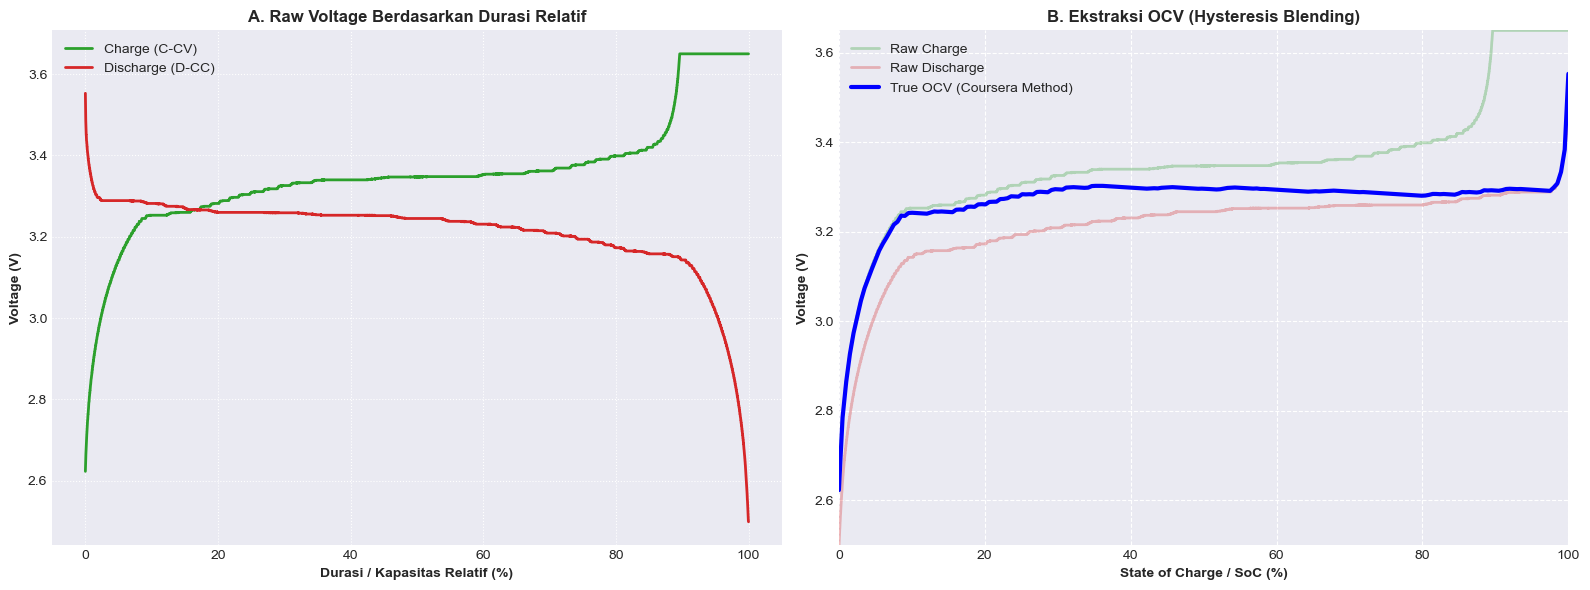

✅ File CSV 'ocv_lookup_table_b.csv' FINAL BERHASIL DISIMPAN!


In [3]:
# =========================================================
# VISUALISASI GRAFIK UNTUK BAB 4 SKRIPSI
# =========================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Raw Voltage vs Durasi
ax1.plot(np.linspace(0, 100, len(ind_Chg)), df_raw['Vol(V)'].iloc[ind_Chg].values, color='tab:green', linewidth=2, label='Charge (C-CV)')
ax1.plot(np.linspace(0, 100, len(ind_Dis)), df_raw['Vol(V)'].iloc[ind_Dis].values, color='tab:red', linewidth=2, label='Discharge (D-CC)')
ax1.set_title('A. Raw Voltage Berdasarkan Durasi Relatif', fontweight='bold')
ax1.set_xlabel('Durasi / Kapasitas Relatif (%)', fontweight='bold')
ax1.set_ylabel('Voltage (V)', fontweight='bold')
ax1.legend()
ax1.grid(True, linestyle=':')

# Plot 2: OCV Extraction (Bentuk Daun Hysteresis)
ax2.plot(chgZ*100, df_raw['Vol(V)'].iloc[ind_Chg].values, color='tab:green', alpha=0.3, linewidth=2, label='Raw Charge')
ax2.plot(disZ*100, df_raw['Vol(V)'].iloc[ind_Dis].values, color='tab:red', alpha=0.3, linewidth=2, label='Raw Discharge')
ax2.plot(SOC_out * 100, True_OCV, color='blue', linewidth=3, linestyle='-', label='True OCV (Coursera Method)')

ax2.set_title('B. Ekstraksi OCV (Hysteresis Blending)', fontweight='bold')
ax2.set_xlabel('State of Charge / SoC (%)', fontweight='bold')
ax2.set_ylabel('Voltage (V)', fontweight='bold')
ax2.set_xlim(0, 100); ax2.set_ylim(2.5, 3.65)
ax2.legend()
ax2.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

# =========================================================
# SIMPAN DATA KE CSV
# =========================================================
df_ocv_final = pd.DataFrame({
    'SoC': SOC_out, 
    'True_OCV': True_OCV
})
df_ocv_final.to_csv('ocv_lookup_table_b.csv', index=False)
print("✅ File CSV 'ocv_lookup_table_b.csv' FINAL BERHASIL DISIMPAN!")